In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# Create a function to update images to array
def images_to_ndarray(images_dir: str, label: int):
  folder_path = 'Data/MedicalMNIST/' + images_dir + '/'
  images_names = sorted(os.listdir(folder_path))
  np_no_label_images = np.array([plt.imread(folder_path + img).flatten() for img in images_names])
  np_label_images = np.zeros((np_no_label_images.shape[0],np_no_label_images.shape[1] + 1),dtype=int)
  np_label_images[:,-1] = np.ones(np_no_label_images.shape[0], dtype=int) * label
  np_label_images[:,:-1] = np_no_label_images
  return np_label_images

## Load data

In [3]:
labels_dict = {0 : 'AbdomenCT', 1 : 'BreastMRI', 2 : 'ChestCT', 3 : 'CXR', 4 : 'Hand', 5 : 'HeadCT'}
label_data_0 = images_to_ndarray(labels_dict.get(0), 0)
label_data_1 = images_to_ndarray(labels_dict.get(1), 1)
label_data_2 = images_to_ndarray(labels_dict.get(2), 2)
label_data_3 = images_to_ndarray(labels_dict.get(3), 3)
label_data_4 = images_to_ndarray(labels_dict.get(4), 4)
label_data_5 = images_to_ndarray(labels_dict.get(5), 5)
data = np.r_[label_data_0, label_data_1, label_data_2, label_data_3, label_data_4, label_data_5]

In [4]:
data.shape

(58954, 4097)

## Splitting train and test dataset

In [5]:
X = data[:,:-1]
y = data[:,-1]

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [7]:
# Chuẩn hoá dữ liệu
X_train = X_train/255.0
X_test = X_test/255.0

## Model selection

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from datetime import datetime

In [10]:
models = [
    KNeighborsClassifier(n_neighbors=6),
    KNeighborsClassifier(n_neighbors=12),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=50),
    RandomForestClassifier(n_estimators=150),
    SVC(kernel='rbf'),
    SVC(kernel='linear')
]

In [11]:
def get_model_name(model):
    model_name = model.__class__.__name__
    if model_name == 'RandomForestClassifier':
        model_name += '_' + str(model.n_estimators)
    elif model_name == 'KNeighborsClassifier':
        model_name += '_' + str(model.n_neighbors)
    elif model_name == 'SVC':
        model_name += '_' + model.kernel

    return model_name

In [12]:
time_start = datetime.now()
# Number of cross validation
cv = 10

# Dataframe to store the model selection results
cv_df = pd.DataFrame(columns=['model', 'mean_score', 'std_score', 'time'])

# Loop through the models
for model in models:
    # Get the model name
    model_name = get_model_name(model)
    # Get the start time
    start_time = datetime.now()
    # Get the cross validation score for the model
    cv_score = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1)
    # Get the end time
    end_time = datetime.now()
    # Get the time taken to train the model
    time_taken = end_time - start_time
    # Append the model name and score to the dataframe
    cv_df = pd.concat([cv_df, pd.DataFrame.from_records([
        {
            'model': model_name,
            'mean_score': cv_score.mean(),
            'std_score': cv_score.std(),
            'time': time_taken,
        }])],
        ignore_index=True,
    )
time_end = datetime.now()
print('Model selection took:', time_end-time_start)

Model selection took: 2:22:24.554625


In [13]:
cv_df.head(10)

,model,mean_score,std_score,time
0,KNeighborsClassifier_6,0.997244,0.00069,0 days 00:04:48.604622
1,KNeighborsClassifier_12,0.996438,0.000957,0 days 00:06:29.999880
2,DecisionTreeClassifier,0.994402,0.000885,0 days 01:20:21.764127
3,RandomForestClassifier_50,0.998897,0.000389,0 days 00:01:46.275561
4,RandomForestClassifier_150,0.998982,0.000656,0 days 00:10:12.413262
5,SVC_rbf,0.999215,0.000502,0 days 00:17:37.333743
6,SVC_linear,0.994508,0.000987,0 days 00:21:08.034301


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'SVC_rbf'),
  Text(1, 0, 'RandomForestClassifier_150'),
  Text(2, 0, 'RandomForestClassifier_50'),
  Text(3, 0, 'KNeighborsClassifier_6'),
  Text(4, 0, 'KNeighborsClassifier_12'),
  Text(5, 0, 'SVC_linear'),
  Text(6, 0, 'DecisionTreeClassifier')])

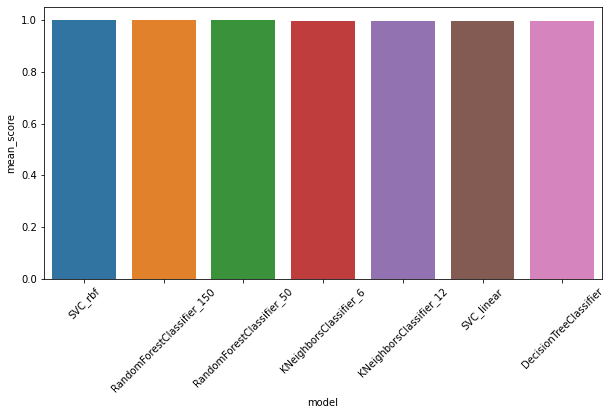

In [14]:
# Plot the cross validation score for the models
plt.figure(figsize=(10, 5))
sns.barplot(x='model', y='mean_score', data=cv_df.sort_values(by='mean_score', ascending=False))
plt.xticks(rotation=45)

#### Comment:
Select model SVC (kernel='rbf') because it has the highest accuracy score and the lower of standard deviation.

### Find the optimal parameter

In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
# Create a dictionary of parameters
param_grid = {'gamma': ['scale', 'auto']}

In [17]:
time_start = datetime.now()
# Combine with GridSearchCV
clf_grid = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=10, n_jobs=-1)
clf_grid.fit(X_train, y_train)
time_end = datetime.now()
print('time taken:', time_end-time_start)

time taken: 0:55:46.885943


In [18]:
# The optimal parameters
print("Best parameters: {}".format(clf_grid.best_params_))
# The highest score
print("Best score: {}".format(clf_grid.best_score_))

Best parameters: {'gamma': 'scale'}
Best score: 0.99921547726871


In [19]:
# Create the best model
clf = SVC(kernel='rbf', gamma=clf_grid.best_params_['gamma'])
clf.fit(X_train, y_train)

SVC()

### Model evaluation

In [20]:
time_start = datetime.now()

kf = KFold(n_splits=10)
train_score = cross_val_score(clf, X_train, y_train, cv=kf)
print('Train score:', train_score.mean(), '+-', train_score.std())
test_score = cross_val_score(clf, X_test, y_test, cv=kf)
print('Train score:', test_score.mean(), '+-', test_score.std())
y_pred = clf.predict(X_test)
print('Accuracy score:', accuracy_score(y_test, y_pred))

print('-------------------------')
time_end = datetime.now()
print('Thời gian chạy mô hình với cross validation:', time_end-time_start)

Train score: 0.9991942773535097 +- 0.0005176509085469725
Train score: 0.9977099955434798 +- 0.00156632448193424
Accuracy score: 0.9989822746162327
-------------------------
Thời gian chạy mô hình với cross validation: 0:12:02.931925


In [21]:
# confusion_matrix và clasification_report
print('confusion_matrix:', confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

confusion_matrix: [[2045    0    0    0    0    0]
 [   0 1751    0    0    0    0]
 [   0    0 1963    0    0    0]
 [   0    0    0 1983    6    0]
 [   0    0    0    1 2017    5]
 [   0    0    0    0    0 2020]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2045
           1       1.00      1.00      1.00      1751
           2       1.00      1.00      1.00      1963
           3       1.00      1.00      1.00      1989
           4       1.00      1.00      1.00      2023
           5       1.00      1.00      1.00      2020

    accuracy                           1.00     11791
   macro avg       1.00      1.00      1.00     11791
weighted avg       1.00      1.00      1.00     11791



#### Comment:
- Model has a high Accuracy score (99%), low error
- High precision, recall and F1 score
> Model predicts with a high accuracy score, it may use to define the Medical MNIST images

## Use PCA to reduce the model running time

In [22]:
from sklearn.decomposition import PCA

In [23]:
pca = PCA(0.9)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

### Carrying on some previous steps:
- Model selection
- Find the optimal parameter
- Model evaluation

#### Model selection

In [24]:
time_start = datetime.now()
# Number of cross validation
cv = 10

# Dataframe to store the model selection results
cv_df_pca = pd.DataFrame(columns=['model', 'mean_score', 'std_score', 'time'])

# Loop through the models
for model in models:
    # Get the model name
    model_name = get_model_name(model)
    # Get the start time
    start_time = datetime.now()
    # Get the cross validation score for the model
    cv_score = cross_val_score(model, X_train_pca, y_train, cv=cv, n_jobs=-1)
    # Get the end time
    end_time = datetime.now()
    # Get the time taken to train the model
    time_taken = end_time - start_time
    # Append the model name and score to the dataframe
    cv_df_pca = pd.concat([cv_df_pca, pd.DataFrame.from_records([
        {
            'model': model_name,
            'mean_score': cv_score.mean(),
            'std_score': cv_score.std(),
            'time': time_taken,
        }])],
        ignore_index=True,
    )
time_end = datetime.now()
print('Model selection took:', time_end-time_start)

Model selection took: 0:03:00.949556


In [25]:
cv_df_pca.sort_values(by='mean_score', ascending=False)

,model,mean_score,std_score,time
5,SVC_rbf,0.999364,0.000493,0 days 00:00:12.083449
0,KNeighborsClassifier_6,0.997965,0.000736,0 days 00:00:08.205636
4,RandomForestClassifier_150,0.997668,0.000741,0 days 00:01:31.739962
1,KNeighborsClassifier_12,0.997456,0.000869,0 days 00:00:07.036390
3,RandomForestClassifier_50,0.99718,0.000747,0 days 00:00:31.166821
6,SVC_linear,0.995187,0.000776,0 days 00:00:21.143527
2,DecisionTreeClassifier,0.992664,0.001166,0 days 00:00:09.554390


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'SVC_rbf'),
  Text(1, 0, 'KNeighborsClassifier_6'),
  Text(2, 0, 'RandomForestClassifier_150'),
  Text(3, 0, 'KNeighborsClassifier_12'),
  Text(4, 0, 'RandomForestClassifier_50'),
  Text(5, 0, 'SVC_linear'),
  Text(6, 0, 'DecisionTreeClassifier')])

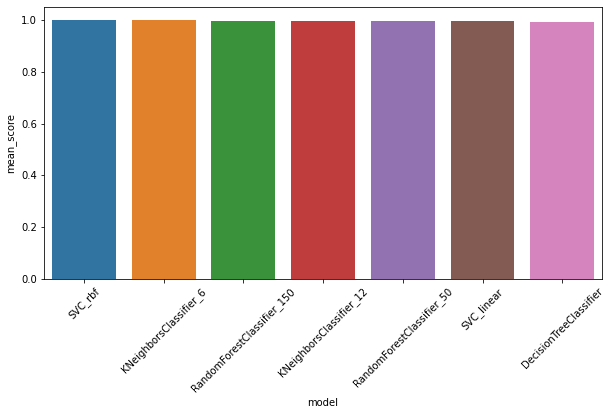

In [26]:
# Plot the cross validation score for the models
plt.figure(figsize=(10, 5))
sns.barplot(x='model', y='mean_score', data=cv_df_pca.sort_values(by='mean_score', ascending=False))
plt.xticks(rotation=45)

#### Find the optimal parameter

In [27]:
time_start = datetime.now()
# Use GridSearchCV
clf_grid_pca = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=10, n_jobs=-1)
clf_grid_pca.fit(X_train_pca, y_train)
time_end = datetime.now()
print('time taken:', time_end-time_start)

time taken: 0:01:12.248159


In [28]:
# The optimal parameter
print("Best parameters: {}".format(clf_grid_pca.best_params_))
# The highest score
print("Best score: {}".format(clf_grid_pca.best_score_))

Best parameters: {'gamma': 'scale'}
Best score: 0.9993638991516975


In [29]:
# Create the best model
clf_pca = SVC(kernel='rbf', gamma=clf_grid_pca.best_params_['gamma'])
clf_pca.fit(X_train_pca, y_train)

SVC()

#### Model evaluation

In [30]:
time_start = datetime.now()

kf = KFold(n_splits=10)
train_score = cross_val_score(clf_pca, X_train_pca, y_train, cv=kf)
print('Train score:', train_score.mean(), '+-', train_score.std())
test_score = cross_val_score(clf_pca, X_test_pca, y_test, cv=kf)
print('Train score:', test_score.mean(), '+-', test_score.std())
y_pred = clf_pca.predict(X_test_pca)
print('Accuracy score:', accuracy_score(y_test, y_pred))

print('-------------------------')
time_end = datetime.now()
print('Thời gian chạy mô hình với cross validation:', time_end-time_start)

Train score: 0.9993427037318143 +- 0.00047836721102960584
Train score: 0.998049266111758 +- 0.0014218585250408162
Accuracy score: 0.99906708506488
-------------------------
Thời gian chạy mô hình với cross validation: 0:00:33.664037


In [31]:
# Xem confusion_matrix và clasification_report
print('confusion_matrix:', confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

confusion_matrix: [[2045    0    0    0    0    0]
 [   0 1751    0    0    0    0]
 [   0    0 1963    0    0    0]
 [   0    0    0 1984    5    0]
 [   0    0    0    1 2017    5]
 [   0    0    0    0    0 2020]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2045
           1       1.00      1.00      1.00      1751
           2       1.00      1.00      1.00      1963
           3       1.00      1.00      1.00      1989
           4       1.00      1.00      1.00      2023
           5       1.00      1.00      1.00      2020

    accuracy                           1.00     11791
   macro avg       1.00      1.00      1.00     11791
weighted avg       1.00      1.00      1.00     11791



#### Conclution: after PCA
- The accuracy score is still high
- Improving significantly execution time (time to select model is just 3 minutes compared to 2 hours and 22 minutes and the execution time and model evaluation with cross validation decreases from 12minutes to just 33 seconds)